

>Dataset download



In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

print("Path to dataset files:", path)


100%|██████████| 158M/158M [00:01<00:00, 86.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2


Global variables

In [2]:
IMG_size = 224
BATCH_size = 32
EPOCHS = 15
LR = 0.0001

**Možná přidat set_seed funkci, abychom měli stále stejné výsledky**

Import libraries

In [3]:
pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 30.5 MB/s eta 0:00:00


In [4]:
# for data preprocessing
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# for model creation
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchmetrics.classification import Accuracy

Dataset augmentation (applying random rotations, etc. to diverify data)

In [5]:
transform = transforms.Compose([
    transforms.Resize((IMG_size, IMG_size), antialias=True),  # Resize images to 224x224 pixels, antialias smoothens the picture after resizing
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Rotate images by up to 10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Adjust brightness and contrast
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
])

# je dobré obrázek jen vyrotovat nebo ho vyrotovat a vytvořit z něj několik obrázků, které pak použiji do trénovacího datasetu

Dataset loading

In [6]:
test_path = path + "/Covid19-dataset/test"
train_path = path + "/Covid19-dataset/train"
data_test = ImageFolder(test_path, transform=transform)
data_train = ImageFolder(train_path, transform=transform)

train_loader = DataLoader(data_train,batch_size=BATCH_size, shuffle=True, drop_last=True)
test_loader = DataLoader(data_test, batch_size=BATCH_size, drop_last=True)

In [7]:
len(data_test), len(data_train)

(66, 251)

In [8]:
for images, labels in train_loader:
    print("Batch of images shape:", images.shape)
    print("Batch of labels shape:", labels.shape)
    break

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])


**Not needed - just to illustrate: function that shows one image from each category**

Class names: ['Covid', 'Normal', 'Viral Pneumonia']


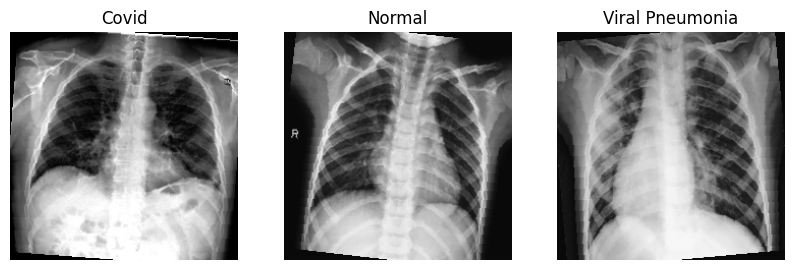

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Class names are derived from the ImageFolder dataset
class_names = data_test.classes  # This gives the class folder names
print("Class names:", class_names)
# Define mean and std for denormalizing (same as used in normalization)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Function to denormalize the image
def denormalize(img, mean, std):
    img = img.clone()  # Clone the tensor to avoid modifying the original
    for i in range(3):  # Apply denormalization per channel
        img[i] = img[i] * std[i] + mean[i]
    return img

# Dictionary to store one image per class
images_per_class = {}

# Iterate over the test dataset to get one image per class
for img, label in data_test:
    if label not in images_per_class:
        images_per_class[label] = img
    if len(images_per_class) == len(class_names):
        break

# Plot each image
fig, axs = plt.subplots(1, len(images_per_class), figsize=(10, 5))
for i, (label, img) in enumerate(images_per_class.items()):
    img = denormalize(img, mean, std)  # Denormalize the image
    img = img.clamp(0, 1)  # Ensure values are in the range [0, 1] for display
    axs[i].imshow(img.permute(1, 2, 0).numpy())  # Convert from [C, H, W] to [H, W, C]
    axs[i].set_title(class_names[label])
    axs[i].axis('off')

plt.show()


Class names: ['Covid', 'Normal', 'Viral Pneumonia']


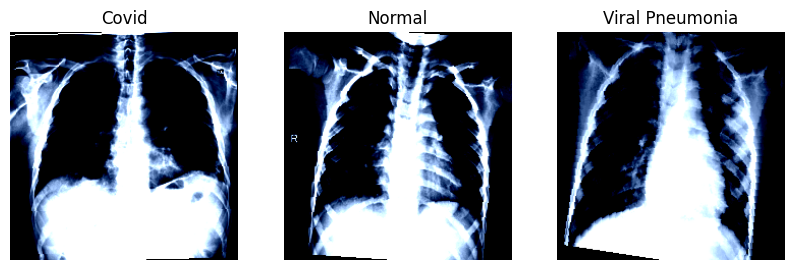

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# Class names are derived from the ImageFolder dataset
class_names = data_test.classes  # This gives the class folder names
print("Class names:", class_names)

# Dictionary to store one image per class
images_per_class = {}

# Iterate over the test dataset to get one image per class
for img, label in data_test:
    # If we don't have an image for this class label, add it to the dictionary
    if label not in images_per_class:
        images_per_class[label] = img
    # Stop if we have one image per class
    if len(images_per_class) == len(class_names):
        break

# Plot each image
fig, axs = plt.subplots(1, len(images_per_class), figsize=(10, 5))
for i, (label, img) in enumerate(images_per_class.items()):
    axs[i].imshow(img.permute(1, 2, 0).numpy())  # Convert from Tensor shape [C, H, W] to [H, W, C]
    axs[i].set_title(class_names[label])
    axs[i].axis('off')

plt.show()


Define model

In [11]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR

class CovidXrayClassifier(pl.LightningModule):
    def __init__(self, num_classes=3, lr=0.0001):
        super(CovidXrayClassifier, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(nn.Dropout(p=0.6), nn.Linear(num_ftrs, num_classes))
        self.lr = lr
        self.criterion = nn.CrossEntropyLoss()
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)

        # Store epoch-level metrics
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = self.train_accuracy(outputs, labels)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = self.val_accuracy(outputs, labels)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.train_losses.append(self.trainer.callback_metrics["train_loss"].item())
        self.train_accs.append(self.trainer.callback_metrics["train_acc"].item())

    def on_validation_epoch_end(self):
        self.val_losses.append(self.trainer.callback_metrics["val_loss"].item())
        self.val_accs.append(self.trainer.callback_metrics["val_acc"].item())

    #def on_train_epoch_end(self):
        # Store metrics for plotting after each epoch
        #if "train_loss" in self.trainer.callback_metrics:
           # self.train_losses.append(self.trainer.callback_metrics["train_loss"].item())
        #if "train_acc" in self.trainer.callback_metrics:
           # self.train_accs.append(self.trainer.callback_metrics["train_acc"].item())

    #def on_validation_epoch_end(self):
        # Store metrics for plotting after each epoch
        #if "val_loss" in self.trainer.callback_metrics:
           # self.val_losses.append(self.trainer.callback_metrics["val_loss"].item())
        #if "val_acc" in self.trainer.callback_metrics:
            #self.val_accs.append(self.trainer.callback_metrics["val_acc"].item())

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-3)
        scheduler = OneCycleLR(optimizer, max_lr=self.lr, steps_per_epoch=len(train_loader), epochs=EPOCHS)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}


Train model

In [12]:
# Initialize and train model
model = CovidXrayClassifier()
#trainer = pl.Trainer(max_epochs=EPOCHS, accelerator='gpu', callbacks=[early_stop_callback])
trainer = pl.Trainer(max_epochs=EPOCHS, accelerator='gpu')
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.uti

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Results

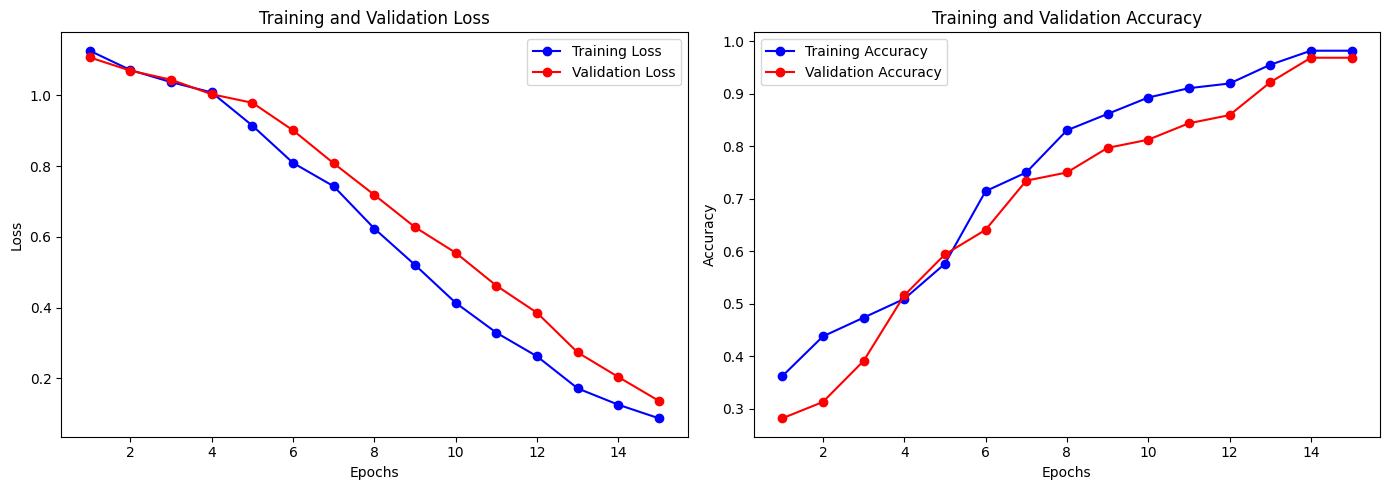

In [13]:
def align_lists(*lists):
    min_length = min(len(lst) for lst in lists)
    return [lst[:min_length] for lst in lists]

# Call the alignment function
train_losses, val_losses, train_accs, val_accs = align_lists(
    model.train_losses, model.val_losses, model.train_accs, model.val_accs
)

# Now, plot the metrics
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the aligned metrics
plot_metrics(train_losses, val_losses, train_accs, val_accs)

Best result so far: **resnet50 - acc: 0.984**

Define average loss function

Cross-Entropy Loss: Best for general multi-class classification tasks where class distribution is relatively balanced.
Focal Loss: Useful for imbalanced datasets or when you want to pay more attention to harder examples.
KL Divergence Loss: Good when working with soft labels or probabilistic predictions.
Label Smoothing Cross-Entropy: Helps to improve generalization and avoid overfitting by preventing the model from being too confident.

Function for classifying given image

In [32]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Define the function to classify a given image, display it, and show the prediction confidence
def classify_image(model, image_path, class_names):
    # Ensure the model is in evaluation mode
    model.eval()

    # Transform the image as per the training pipeline
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match model input
        transforms.ToTensor(),          # Convert image to PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    ])

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Ensure the image is RGB
    image_tensor = transform(image).unsqueeze(0)   # Add batch dimension

    # Perform the classification
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)  # Convert logits to probabilities
        confidence, predicted_class = torch.max(probabilities, 1)  # Get the confidence and class index

    # Print the predicted class label and confidence
    predicted_label = class_names[predicted_class.item()]
    confidence_score = confidence.item() * 100  # Convert to percentage
    print(f'Predicted class: {predicted_label} with confidence: {confidence_score:.2f}%')

    # Display the image
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_label} ({confidence_score:.2f}%)')
    plt.axis('off')
    plt.show()

    # Return the class label and confidence
    return predicted_label, confidence_score


Predicted class: COVID-19 with confidence: 92.47%


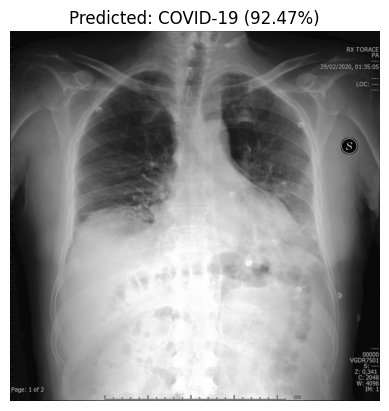

In [33]:
# Example usage
image_path = path + "/Covid19-dataset/test/Covid/098.jpeg" # I chose one random image
predicted_label = classify_image(model, image_path, class_names)